In [1]:
# %%
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 7) # for Prophet plot when applying log transform

import numpy as np
import pandas as pd
import sklearn.metrics

In [2]:
# test with other smoothing functions

In [3]:
# %%
df = pd.read_csv('emerging_risks_doc_count_twitter.csv')

try:
    df.drop([381, 382, 383], inplace=True) # drop rows 381, 382, 383 as they are 0 values
    df.set_index('date', inplace=True)     # set date as index
except KeyError:                          # pass if rows 381, 382, 383 have already been dropped
    pass


weekly = df.Pesticides.rolling(7).mean()[7:]
smoothed = df.Pesticides.rolling(9).mean()[9:]
topic = df.Pesticides

In [4]:
def remove_outliers(series, cutoff: int):
    std = series.std()
    print("# of Peaks: ", len(series[series > cutoff * series.std()])) # None
    print("# of Falls: ", len(series[series < series.std() / cutoff]))
    
    series.plot()
    
    ser = series.copy()

    ser.loc[ser > (cutoff * std)] = None
    ser.loc[ser < std / cutoff] = None

    ser.fillna(method='ffill', inplace=True)
    ser.fillna(method='backfill', inplace=True) # replace first value if NaN
        
    ser.plot()
    return ser

# of Peaks:  51
# of Falls:  0


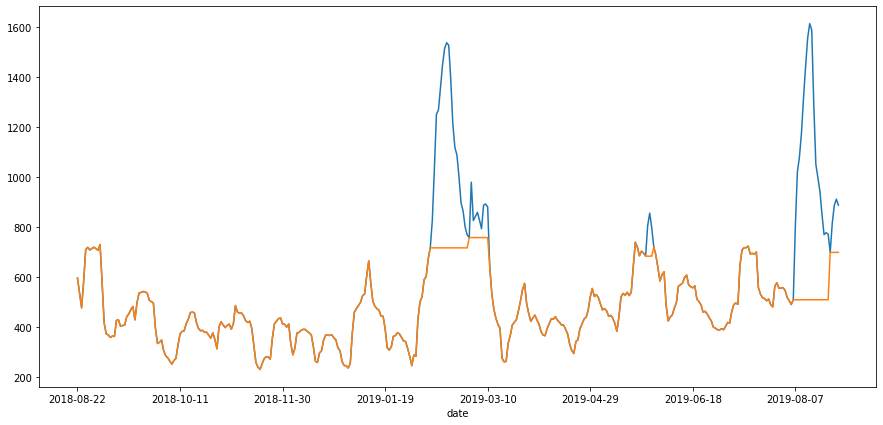

In [5]:
pkless_smoothed = remove_outliers(smoothed, 3)

# of Peaks:  23
# of Falls:  3


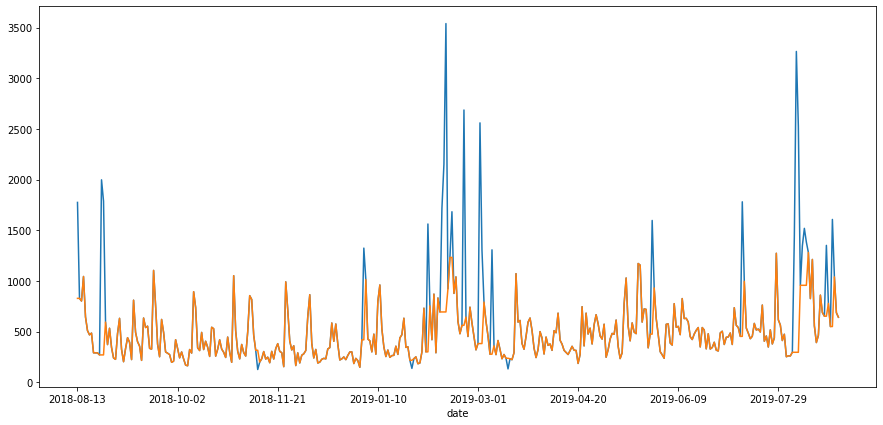

In [6]:
pkless_topic = remove_outliers(topic, 3)

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError(f"len y_true is {len(y_true)}, len y_pred is {len(y_true)}" )
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
def prophetize(ser, prediction_length=28, holidays=False, changepoint_prior_scale=0.05, apply_log=False) \
        -> dict:
    """
    Plot fit and prediction, print error measurements, return dict 
    {'MAPE': float, 'R2': float, 'RMSE': float, 'Model': Prophet, 'Future': pd.DataFrame}.
    """
    if type(holidays) is str:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
        m.add_country_holidays(country_name=holidays)
    elif type(holidays) is pd.DataFrame:
        m = Prophet(holidays=holidays, changepoint_prior_scale=changepoint_prior_scale)
    elif holidays is False:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
    else:
        raise TypeError(f"holidays must be str, pd.DataFrame or False, is {type(holidays)} instead.")
    
    m.add_seasonality(name='quarterly', period=120, fourier_order=5)
    
    df = pd.DataFrame()
    if apply_log is False:
        df["y"] = ser
    else:
        df["y"] = np.log(ser)
    df["ds"] = ser.index

    m.fit(df)
    future = m.make_future_dataframe(periods=prediction_length)
    forecast = m.predict(future)

    if apply_log is True:
        for col_name in ('yhat', 'yhat_lower', 'yhat_upper'):
            forecast[col_name] = np.exp(forecast[col_name])
        df.y = np.exp(df.y)
        
    pred = forecast.yhat[:-prediction_length] 
    mape = mean_absolute_percentage_error(df.y, pred)
    rsquared = sklearn.metrics.r2_score(df.y, pred)
    rmse = sklearn.metrics.mean_squared_error(df.y, pred, squared=False)

    res = {"MAPE": mape, "R2": rsquared, "RMSE": rmse}
    for k, v in res.items():
        print(k, " : ", v) 
    res["Model"] = m
    res["Future"] = future
    
    if apply_log is False:
        m.plot(forecast)
        plt.show()        
    
    else:
        forecast.set_index(forecast.ds, inplace=True)
        fig, ax1 = plt.subplots()
        ax1.plot(df.y)
        ax1.plot(forecast.yhat, color='black', linestyle=':')
        ax1.fill_between(forecast.index, forecast['yhat_upper'], forecast['yhat_lower'], alpha=0.5, 
                         color='darkgray')
    return res

# SIMPLE Prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  52.713696931095946
R2  :  0.11966541791223473
RMSE  :  404.36459780161397


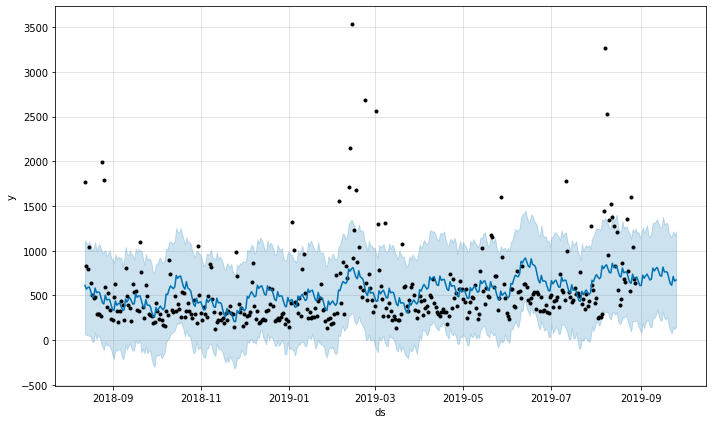

In [94]:
simple = prophetize(topic)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  38.06732476356766
R2  :  0.16810599959737837
RMSE  :  209.40836724660372


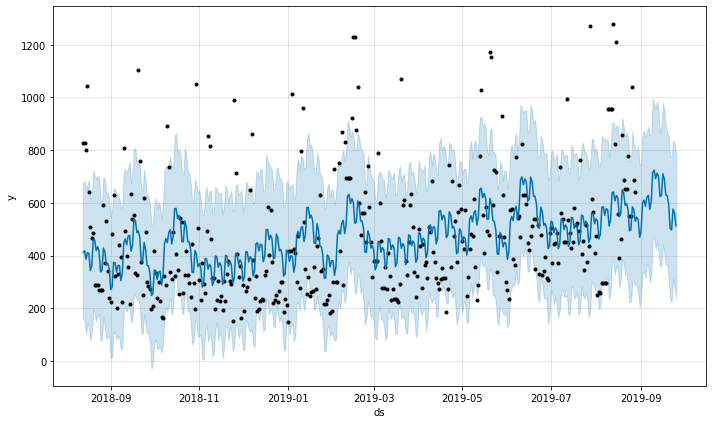

In [75]:
pkless_simple = prophetize(pkless_topic)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  15.327458908814403
R2  :  0.45765488679628585
RMSE  :  82.39289947450487


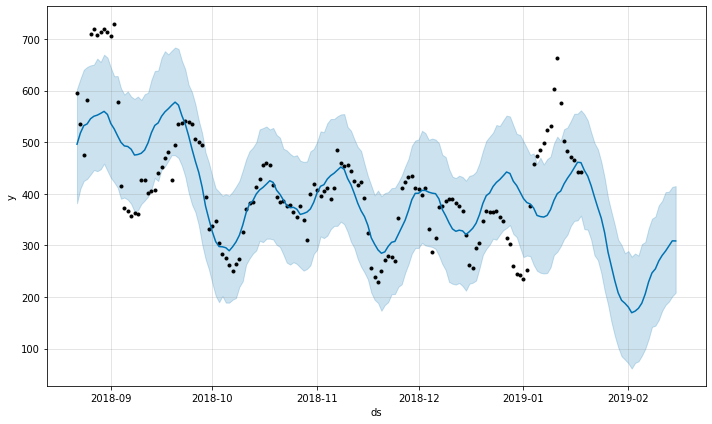

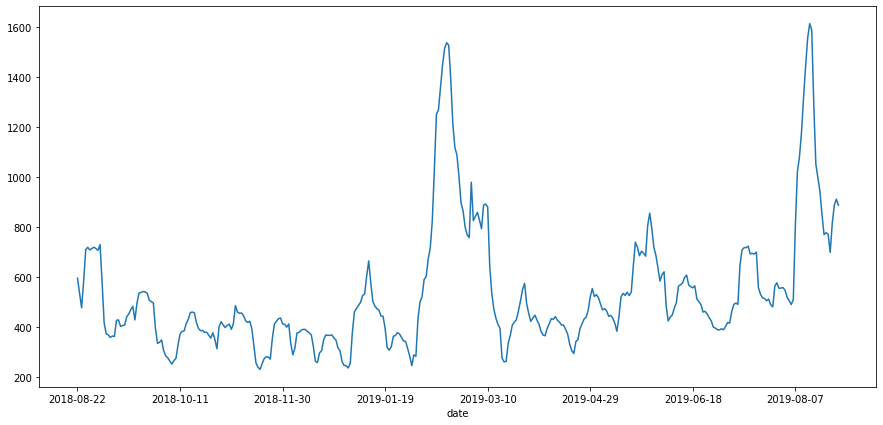

In [13]:
# increasing flexibility leads to good result
simple_smoothed = prophetize(smoothed[:150])
smoothed.plot()


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  32.78436110973359
R2  :  0.26581649680927855
RMSE  :  232.7292938329615


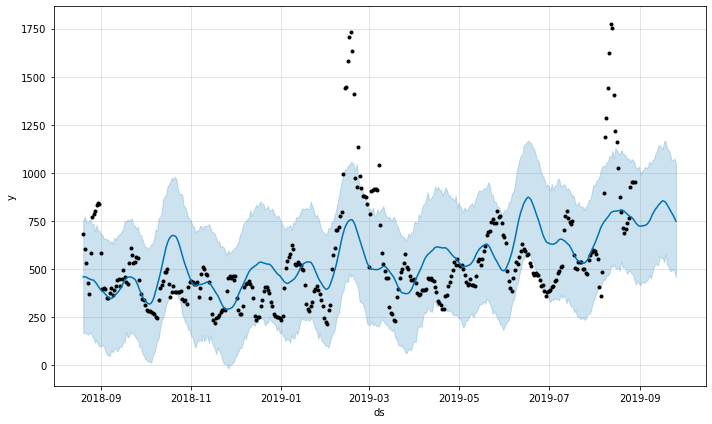

In [97]:
# increasing flexibility leads to good result
simple_weekly = prophetize(weekly)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  11.891571031345421
R2  :  0.7681175347549457
RMSE  :  66.2142592613445


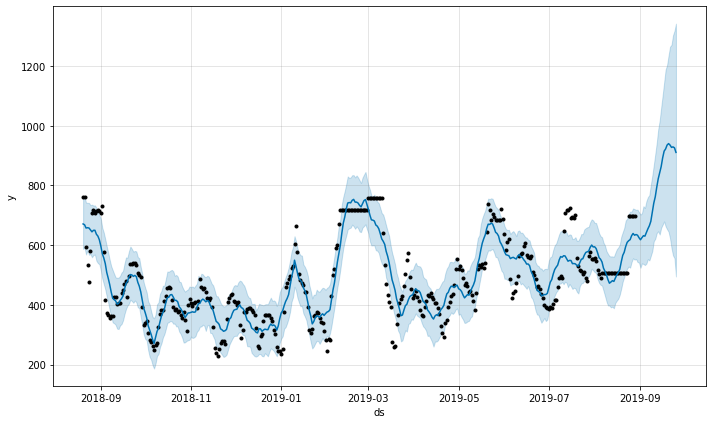

In [86]:
# without increasing flexibility, it fails. From changepoint_prior_scale=3 it gets really good
# PROBLEM: LAST BUT ONE PEAK IS REMOVED DURING SMOOTHING, THIS CHANGES FORECAST. POSSIBLE SOLUTION: REPLACE ffill with 
        # values within cutout * std.
pkless_simple = prophetize(pkless_smoothed, changepoint_prior_scale=3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  24.6736570629192
R2  :  0.41482280729810206
RMSE  :  208.23132892316966


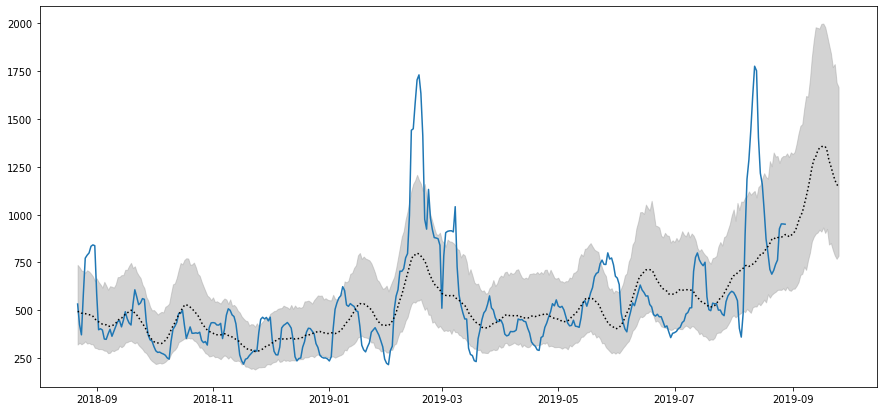

In [48]:
simple = prophetize(smoothed, apply_log=True)

# US Holidays
MAPE lowers by 2%: 2 peaks (on the general dataset as well) seem to be correlated with 2 US holidays
### Watch out:
Since we only have 1 year, we cannot really take into account the impact of holidays. We will see overfitting
bias

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  23.672629463491752
R2  :  0.28905607342518136
RMSE  :  133.64768038469307


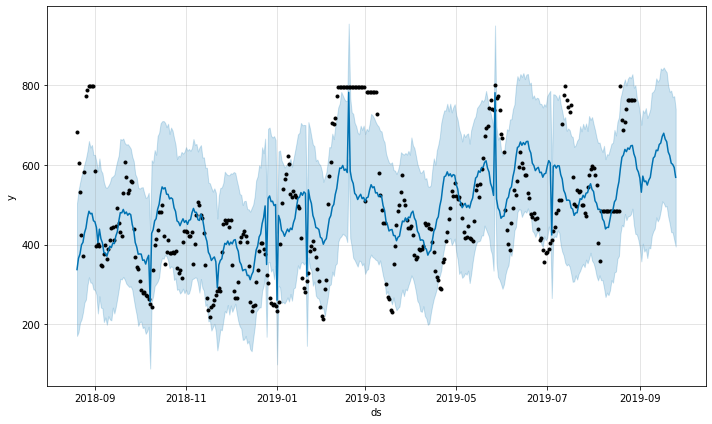

In [12]:
us = prophetize(topic, holidays="US")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  20.085640047981602
R2  :  0.40738396564893464
RMSE  :  122.01983972185953


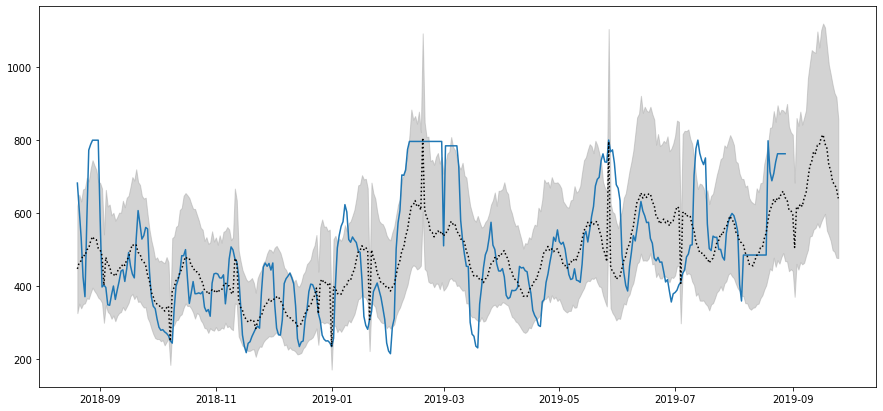

In [13]:
us = prophetize(topic, holidays="US", apply_log=True)

# French holidays
Interetingly enough, French holidays seem to be correlated with 2 other peaks.
We probably see this because the dataset is global.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  23.736988858491404
R2  :  0.28360997063303284
RMSE  :  134.15860000297275


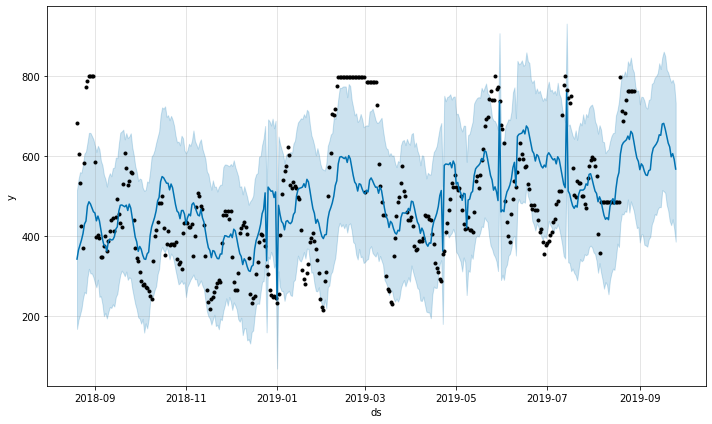

In [14]:
fr = prophetize(topic, holidays="FRA")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  20.107040268436872
R2  :  0.41917432179577696
RMSE  :  120.79992240288956


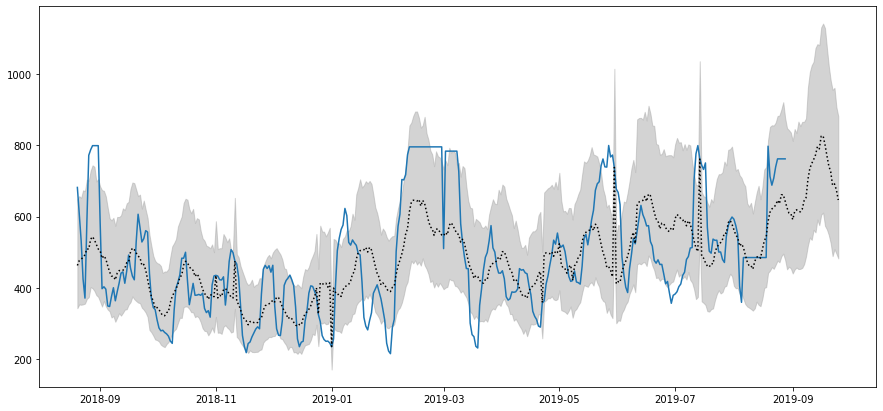

In [15]:
fr = prophetize(topic, holidays="FRA", apply_log=True)

# Reductio ad absurdum
Let's see how much the MAPE would get down if I knew in advance all top and bottom periods on the dataset as 
a whole

In [16]:
# %%
# ds_outliers lists the top/bottom days of the dataset as a whole
#h_full = pd.read_csv('C:/Users/Lorenzo/Desktop/MyStuff/Master/Paris/Bloom/Prophet/data/artefact_holidays.csv')
h_full = pd.read_csv('C:/Users/Lorenzo/Desktop/MyStuff/Master/Paris/Bloom/Prophet/data/ds_outliers.csv')
# h_full = pd.read_csv('ds_outliers.csv')
h_full.ds = pd.to_datetime(h_full.ds)
h_full.lower_window = pd.to_numeric(h_full.lower_window)
h_full.upper_window = pd.to_numeric(h_full.upper_window)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  18.994038205867657
R2  :  0.42268354187207013
RMSE  :  120.43444635015102


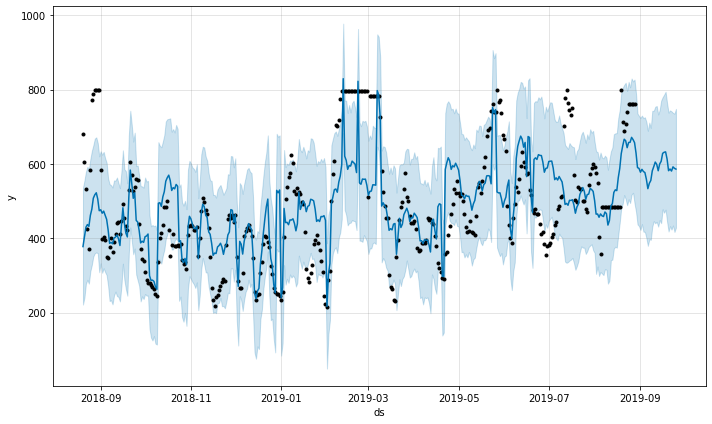

In [17]:
cheating = prophetize(topic, holidays=h_full)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  14.76606261574318
R2  :  0.5450547757312167
RMSE  :  106.91122516322179


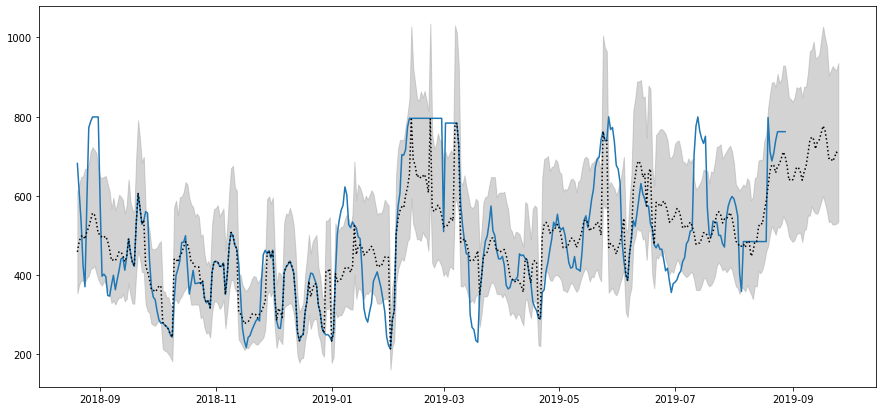

In [18]:
cheating = prophetize(topic, holidays=h_full, apply_log=True)

# a MAPE of 41% is still extremely high. The model is not able to reliably fit the data.
Now I try to increase the "flexibility" of the model with the parameter changepoint_prior_scale

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  10.734701348415124
R2  :  0.7911133904315732
RMSE  :  72.44343782031085


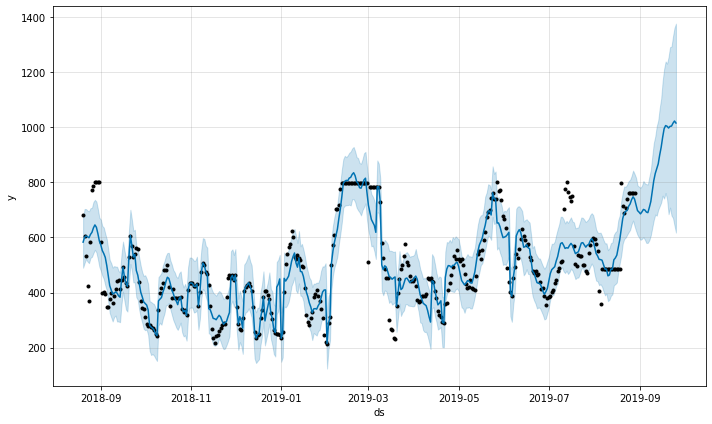

In [19]:
flex_cheating = prophetize(topic, holidays=h_full, changepoint_prior_scale=3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAPE  :  9.989687305446976
R2  :  0.8012492238873193
RMSE  :  70.663991929248


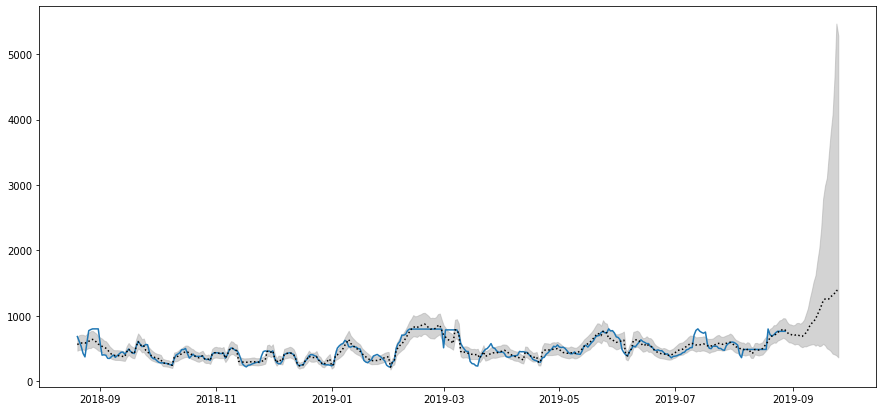

In [20]:
flex_cheating = prophetize(topic, holidays=h_full, changepoint_prior_scale=3, apply_log=True)

# Increasing the flexibility lowers the MAPE to an almost acceptable MAPE of 32%, but we see an increase in overfitting

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


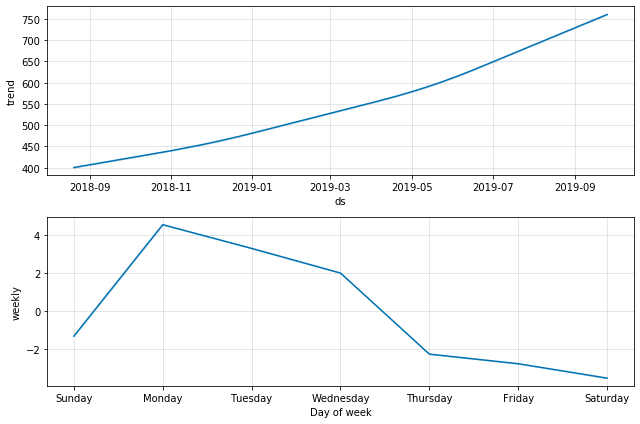

In [25]:
# %%
a = smoothed
prophet_df = pd.DataFrame()
prophet_df["y"] = a
prophet_df["ds"] = a.index
m = Prophet()
m.fit(prophet_df)
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)
fig2 = m.plot_components(forecast)
plt.show()

In [26]:
# diagnostics take a long computing time
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='180 days', period='28 days', horizon = '14 days')
df_cv.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-02-27 00:00:00 and 2019-08-14 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-02-28,972.052342,722.495541,1220.253961,839.285714,2019-02-27
1,2019-03-01,991.589638,721.355351,1230.847916,510.000000,2019-02-27
2,2019-03-02,1000.950926,761.992229,1238.304283,783.857143,2019-02-27
3,2019-03-03,1009.427454,747.982080,1252.376387,905.285714,2019-02-27
4,2019-03-04,1025.741913,771.604844,1267.301012,912.428571,2019-02-27


In [27]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,2 days,85913.827929,293.110607,234.211750,0.361336,0.321514,0.746032
1,3 days,57303.476878,239.381446,196.771983,0.304088,0.276956,0.825397
2,4 days,33573.492183,183.230708,149.343850,0.241539,0.245859,0.968254
3,5 days,29925.586687,172.990135,137.346707,0.226312,0.164844,1.000000
4,6 days,28823.859223,169.775909,132.724341,0.235101,0.124189,1.000000


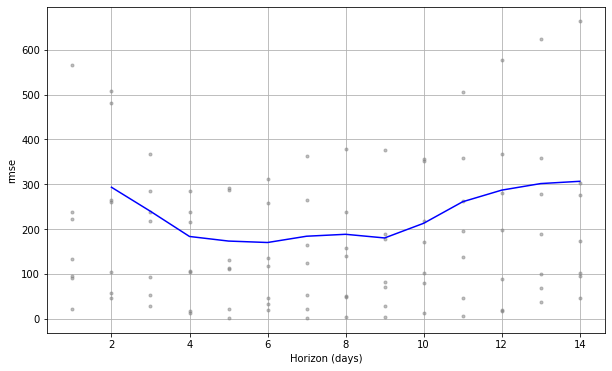

In [28]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [119]:
from pmdarima import auto_arima

stepwise_model = auto_arima(smoothed, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())
res = stepwise_model.fit(smoothed)
future_forecast = stepwise_model.predict(n_periods=28)

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=3915.882, BIC=3935.299, Time=1.630 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=4219.053, BIC=4226.820, Time=0.075 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=4018.298, BIC=4033.831, Time=1.111 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=3923.556, BIC=3939.089, Time=1.144 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=4217.109, BIC=4220.993, Time=0.050 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=4123.635, BIC=4139.168, Time=0.565 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=3917.240, BIC=3940.540, Time=2.721 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse r

In [120]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
r = SARIMAX(smoothed, order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
fit_sarimax = r.fit()

# In-sample one-step-ahead predictions
predict = fit_sarimax.get_prediction()
predict_ci = predict.conf_int()

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [121]:
fit_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Pesticides   No. Observations:                  372
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1952.343
Date:                              Tue, 28 Apr 2020   AIC                           3916.686
Time:                                      11:44:15   BIC                           3939.986
Sample:                                  08-22-2018   HQIC                          3925.952
                                       - 08-28-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6420      1.009      0.636      0.525      -1.336       2.620
ar.L2         -0.0136      0.459     -0.030      0.976      -0.913       0.886
ma.L1         -0.1549      1.003     -0.154      0.877      -2.121       1.811
ma.L2         -0.1281      0.115     -1.117      0.264      -0.353       0.097
ma.S.L12      -0.9982      1.758     -0.568      0.570      -4.444       2.448
sigma2      2768.2904   4765.304      0.581      0.561   -6571.535    1.21e+04
===================================================================================
Ljung-Box (Q):                      123.88   Jarque-Bera (JB):               931.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.63   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

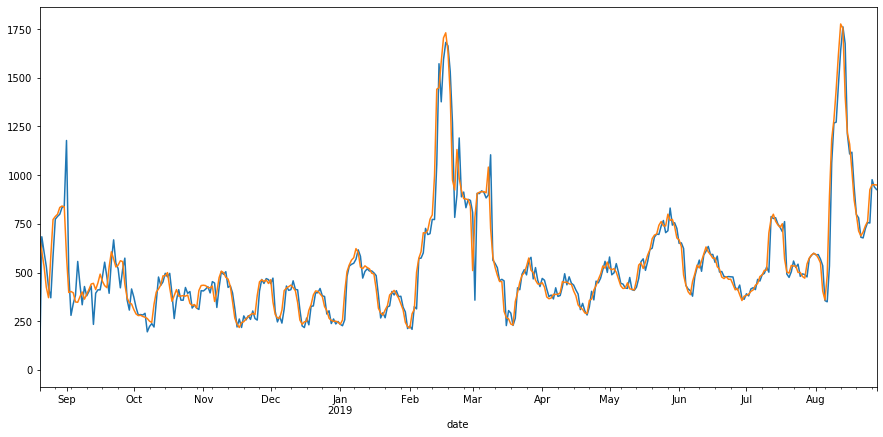

In [32]:
predict.predicted_mean.plot()
smoothed.plot()

In [122]:
mean_absolute_percentage_error(smoothed, predict.predicted_mean)

7.373894723201277

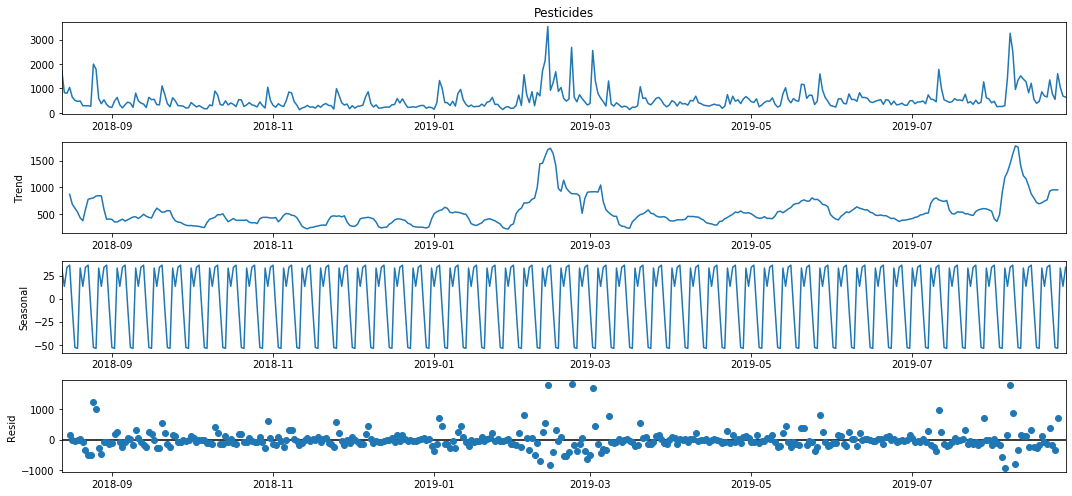

In [123]:
# only weekly trend is identified BECAUSE only 1 year of data and lack of monthly seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(topic, model='additive')
fig = result.plot()

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



60.050993919201915


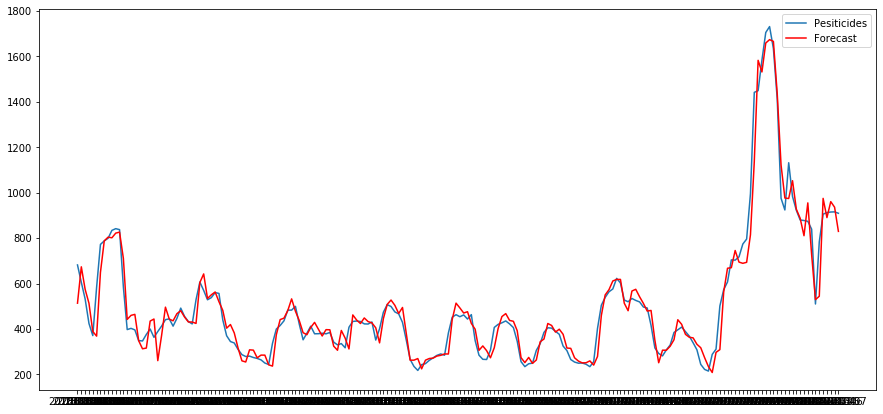

In [6]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

reg = weekly[:200]
ARIMA_model = ARIMA(reg, order=(9, 0, 4)).fit()
print(sklearn.metrics.mean_squared_error(reg, ARIMA_model.fittedvalues, squared=False))
plt.plot(reg, label="Pesiticides")
plt.plot(ARIMA_model.fittedvalues, color='red', label="Forecast")
plt.legend(loc='best')
plt.show()

In [7]:
# FORECAST is accurate only for first 2 days
plt.plot(weekly, label="Pesiticides")
plt.plot(ARIMA_model.predict(200, 300))

2019-03-08    959.669381
2019-03-09    771.175120
2019-03-10    601.342300
Freq: D, dtype: float64


ValueError: view limit minimum -36861.3 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [157]:
predict_dy = ARIMA_model.get_prediction(dynamic='2018-15-11')
predict_dy_ci = predict_dy.conf_int()
predict_dy.predicted_mean.loc['2018-15-10':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc['2018-15-10':]

AttributeError: 'ARMAResults' object has no attribute 'get_prediction'

In [126]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Pesticides   No. Observations:                  374
Model:                     ARMA(9, 4)   Log Likelihood               -2047.303
Method:                       css-mle   S.D. of innovations             57.178
Date:                Tue, 28 Apr 2020   AIC                           4124.606
Time:                        11:45:24   BIC                           4183.469
Sample:                    08-20-2018   HQIC                          4147.977
                         - 08-28-2019                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              550.4766     62.139      8.859      0.000     428.687     672.267
ar.L1.Pesticides     1.5485      0.344      4.499      0.000       0.874       2.223
ar.L2.Pesticides    -0.8749      0.317     -2.758      0.006      -1.497      -0.253
ar.L3.Pesticides     0.6457      0.166      3.895      0.000       0.321       0.971
ar.L4.Pesticides    -0.3816      0.209     -1.823      0.068      -0.792       0.029
ar.L5.Pesticides    -0.0102      0.156     -0.066      0.948      -0.316       0.295
ar.L6.Pesticides     0.1394      0.114      1.220      0.222      -0.085       0.363
ar.L7.Pesticides    -0.6800      0.098     -6.953      0.000      -0.872      -0.488
ar.L8.Pesticides     0.9313      0.223      4.169      0.000       0.493       1.369
ar.L9.Pesticides    -0.3602      0.169     -2.134      0.033      -0.691      -0.029
ma.L1.Pesticides    -0.0605      0.346     -0.175      0.861      -0.739       0.618
ma.L2.Pesticides     0.2857      0.247      1.159      0.247      -0.198       0.769
ma.L3.Pesticides    -0.2641      0.266     -0.992      0.321      -0.786       0.258
ma.L4.Pesticides    -0.0603      0.159     -0.380      0.704      -0.372       0.251
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1284           -0.0000j            1.1284           -0.5000
AR.2           -0.5801           -0.8687j            1.0446           -0.3437
AR.3           -0.5801           +0.8687j            1.0446            0.3437
AR.4            0.1776           -1.0434j            1.0585           -0.2232
AR.5            0.1776           +1.0434j            1.0585            0.2232
AR.6            1.0491           -0.5321j            1.1763           -0.0747
AR.7            1.0491           +0.5321j            1.1763            0.0747
AR.8            1.1063           -0.0000j            1.1063           -0.0000
AR.9            1.3148           -0.0000j            1.3148           -0.0000
MA.1           -0.3255           -1.3173j            1.3569           -0.2886
MA.2           -0.3255           +1.3173j            1.3569            0.2886
MA.3            1.6686           -0.0000j            1.6686           -0.0000
MA.4           -5.3974           -0.0000j            5.3974           -0.5000
-----------------------------------------------------------------------------
"""

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



46.16210743323808


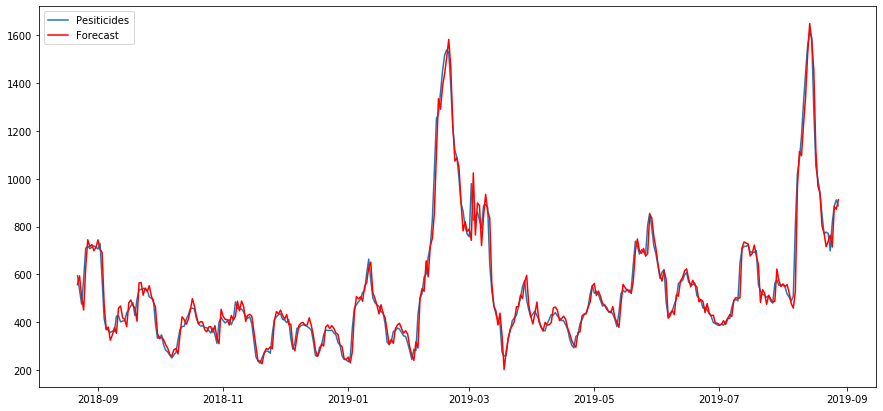

In [130]:
reg = smoothed
ARIMA_model = ARIMA(reg, order=(9, 0, 4)).fit()
print(sklearn.metrics.mean_squared_error(reg, ARIMA_model.fittedvalues, squared=False))
plt.plot(reg, label="Pesiticides")
plt.plot(ARIMA_model.fittedvalues, color='red', label="Forecast")
plt.legend(loc='best')
plt.show()

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\Lorenzo\miniconda3\envs\Prophet\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



105.37723578712637


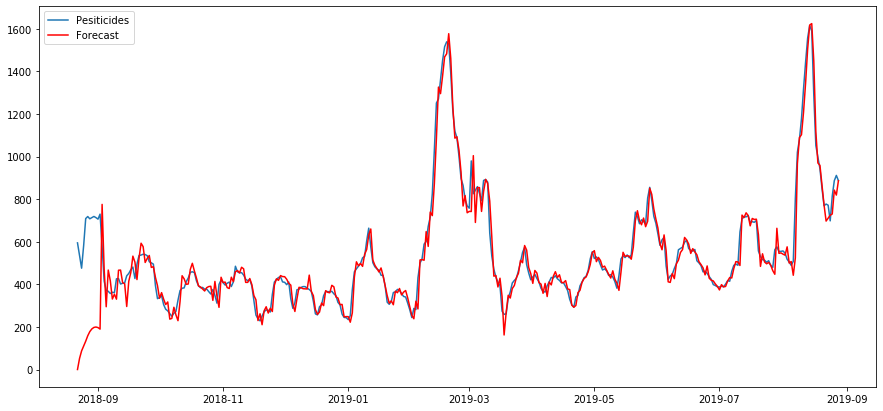

In [131]:
reg = smoothed
ARIMA_model = SARIMAX(reg, order=(9, 0, 4), seasonal_order=(1,1,1,12)).fit()
print(sklearn.metrics.mean_squared_error(reg, ARIMA_model.fittedvalues, squared=False))
plt.plot(reg, label="Pesiticides")
plt.plot(ARIMA_model.fittedvalues, color='red', label="Forecast")
plt.legend(loc='best')
plt.show()